# Test Strategies against S&P 500 Baseline


In [1]:
import sys
sys.executable

'/home/hilton/Coding/Dashboard/backtest-env/bin/python'

# Section 0 - Config and Imports

In [2]:
import numpy as np
import pandas as pd
import datetime
import yfinance as yf
import time

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy import stats
from typing import Dict, Callable, Optional

import pandas as pd
from pathlib import Path
from datetime import date
import requests


import warnings
warnings.filterwarnings("ignore")


# -------------------------
# Global constants
# -------------------------
TRADING_DAYS = 252
RISK_FREE_RATE = 0.0

PLOT_STYLE = {
    "figure.figsize": (14, 6),
    "axes.grid": True,
    "grid.alpha": 0.3,
    "axes.spines.top": False,
    "axes.spines.right": False
}

plt.rcParams.update(PLOT_STYLE)



In [17]:
def downloadTickerUniverse():    
    BASE_DIR = Path.home() / "data" / "universes"
    BASE_DIR.mkdir(parents=True, exist_ok=True)

    SEC_URL = "https://www.sec.gov/files/company_tickers.json"
    SEC_PATH = BASE_DIR / "company_tickers.json"

    headers = {
        "User-Agent": "researcher reynoldsb200@gmail.com"
    }

    if not SEC_PATH.exists():
        r = requests.get(SEC_URL, headers=headers, timeout=(5, 30))
        r.raise_for_status()
        SEC_PATH.write_bytes(r.content)

    sec_data = pd.read_json(SEC_PATH)

    sec_data = sec_data.T
    sec_data["ticker"] = sec_data["ticker"].str.upper()

    sec_data.to_csv(BASE_DIR / "sec_ticker_cik_raw.csv", index=False)

    universe = (
        sec_data["ticker"]
        .dropna()
        .str.strip()
        .unique()
    )

    universe = pd.DataFrame({"ticker": universe})

    universe_path = BASE_DIR / "us_equity_universe_master.csv"
    universe.to_csv(universe_path, index=False)

    #print(f"Universe size: {len(universe)}")
    #print(universe.head())

    return universe


In [4]:
def extractTicker(tickerNames):
    errors = {}
    data = {}
    for ticker in tickerNames:
        time.sleep(0.02)
        df = yf.download(ticker, period="25y", progress=False)

        if df.empty or df.filter(like="Close").isna().all().all():
            errors[ticker] = "invalid ticker or no usable data"
            continue
        
        startDate = df.index.min()
        RequiredstartDate = pd.Timestamp.today() - pd.DateOffset(years=2)

        if startDate > RequiredstartDate:
            errors[ticker] = "insufficient history"
            continue

        data[ticker] = {
            "prices": df
        }

    return data, errors


In [ ]:
def extractFundementals(tickerNames, batch_size = 20, delay = 1.5):
    f_errors = {}
    fundementals = []
    
    asof = pd.Timestamp.today()

    total_batches = (len(tickerNames) + batch_size - 1) //batch_size

    for batch_index in range(0, len(tickerNames), batch_size):
        batch = tickerNames[batch_index:batch_index + batch_size]
        current_batch_num = (batch_index // batch_size) + 1
        print(f"  Batch {current_batch_num}/{total_batches}: Processing {len(batch)} tickers")
        
        for ticker in batch:
            try:
                info = yf.Ticker(ticker).info
            except Exception as e:
                f_errors[ticker] = f"fetch info failed: {e}"
                continue

    
            PE = info.get("trailingPE", np.nan)
            Market_Cap = info.get("marketCap", np.nan)
            BookValue_PerShare = info.get("bookValue", np.nan)
            Intangible = info.get("intangibleAssets", np.nan)
            Shares_Outstanding = info.get("sharesOutstanding", np.nan)

            if(pd.notna(BookValue_PerShare)
            and pd.notna(Shares_Outstanding)
            and pd.notna(Market_Cap)):
                Book = float(BookValue_PerShare) * float(Shares_Outstanding)
                BooktoMarket = Book / float(Market_Cap)
            else:
                Book, BooktoMarket = np.nan, np.nan

            if (pd.notna(Book)
                and pd.notna(Intangible)):
                tangibleBook = Book - float(Intangible)
                tangibleBooktoMarket = tangibleBook/float(Market_Cap)
            else: 
                tangibleBook, tangibleBooktoMarket = np.nan, np.nan

            fundementals.append({
                "ticker": ticker,
                "PE": PE,
                "Market_Cap": Market_Cap,
                "BookValue_PerShare": BookValue_PerShare,
                "Intangible": Intangible,
                "Shares_Outstanding": Shares_Outstanding,
                "Book": Book,
                "BooktoMarket": BooktoMarket,
                "TangibleBook": tangibleBook,
                "TangibleBooktoMarket": tangibleBooktoMarket
            })
        if batch_index + batch_size < len(tickerNames):
            actual_delay = delay + np.random.uniform(-0.3, 0.3)
            time.sleep(max(0.5, actual_delay))
    
    print(f"Completed! Successfully processed {len(fundementals)} tickers")
    if f_errors:
        print(f"Encountered errors for {len(f_errors)} tickers")
    

    fundementals_df = pd.DataFrame(fundementals).set_index("ticker")
    return fundementals_df, f_errors    

    

In [ ]:
def filterUniverseByMarketCap(
    universe,
    mcap_max=None,
    price_min=None,
    volume_min=None,
    sleep=0.02
):
    import yfinance as yf
    import time
    import pandas as pd

    rows = []

    for t in universe:
        try:
            info = yf.Ticker(t).fast_info
            mc = info.get("market_cap")

            if mc is None:
                continue
            if mcap_max is not None and mc >= mcap_max:
                continue
            if price_min is not None and info.get("last_price", 0) < price_min:
                continue
            if volume_min is not None and info.get("last_volume", 0) < volume_min:
                continue

            rows.append({"ticker": t, "Market_Cap": mc})
            time.sleep(sleep)

        except Exception:
            continue
        
    if not rows:
        return pd.DataFrame(columns=["Market_Cap"])
    
    return pd.DataFrame(rows).set_index("ticker")




In [ ]:
def dynamicScreen(tickers, pe_max=None, tbm_min=None, mcap_max=None, pe_or_tbm=None, batch_size=20, delay=1.5):
    #downloadTickerUniverse()
    

    fundementals, f_errors = extractFundementals(tickers, batch_size=batch_size, delay=delay)
    if fundementals.empty:
        print("rate limited")
        return [], pd.DataFrame()
    
    f=fundementals.copy()

    f["PE"] = pd.to_numeric(f["PE"], errors='coerce')

    core = pd.Series(True, index=f.index)

    if pe_max is not None and "PE" in f.columns:
        pe_cond = f["PE"].notna() & (f["PE"] < pe_max)
    else:
        pe_cond = pd.Series(True, index=f.index)
    
    if tbm_min is not None and "TangibleBooktoMarket" in f.columns: 
        tbm_cond = (
        f["TangibleBooktoMarket"].notna() &
        (f["TangibleBooktoMarket"] >= tbm_min)
        )
    else: 
        tbm_cond = pd.Series(True, index=f.index)

    if pe_or_tbm: 
        core &= (pe_cond | tbm_cond)
    else:
        core &= (pe_cond & tbm_cond)
    
    if mcap_max is not None and "Market_Cap" in f.columns:
        core &= f["Market_Cap"] < mcap_max
    
    selected = f.loc[core]

    return selected.index.tolist(), selected    

In [8]:
tickerNames = ["^GSPC", "KINS"]

data, errors = extractTicker(tickerNames)
fundementals, f_errors = extractFundementals(tickerNames)

In [9]:
data

{'^GSPC': {'prices': Price             Close         High          Low         Open      Volume
  Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
  Date                                                                      
  2001-01-22  1342.900024  1353.619995  1333.839966  1342.540039  1164000000
  2001-01-23  1360.400024  1362.900024  1339.630005  1342.900024  1232600000
  2001-01-24  1364.300049  1369.750000  1357.280029  1360.400024  1309000000
  2001-01-25  1357.510010  1367.349976  1354.630005  1364.300049  1258000000
  2001-01-26  1354.949951  1357.510010  1342.750000  1357.510010  1098000000
  ...                 ...          ...          ...          ...         ...
  2026-01-12  6977.270020  6986.330078  6934.069824  6944.120117  5019040000
  2026-01-13  6963.740234  6985.830078  6938.770020  6977.410156  5091730000
  2026-01-14  6926.600098  6941.299805  6885.740234  6937.410156  5530830000
  2026-01-15  6944.470215  6979.339844  6937.930176  6969

In [10]:
fundementals.head()

,PE,Market_Cap,BookValue_PerShare,Intangible,Shares_Outstanding,Book,BooktoMarket,Tangible Book,TangibleBooktoMarket
ticker,,,,,,,,,
^GSPC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KINS,7.004445,222963472.0,7.609,NaN,14147428.0,1.076478e+08,0.482805,NaN,NaN


# Section 1 - Base Feature Engineering

### Daily Return

$$
r_t = \frac{C_t}{C_{t-1}} - 1
$$


In [11]:
df = data["^GSPC"]["prices"]
df["Daily Return"] = df["Close"].pct_change()
df = df.dropna()

### Equity Curve

$$
E_t = \prod_{i=1}^{t} \left(1 + r_i\right)
$$
$$
E_0 = 1
$$



In [12]:
df["Equity Curve"] = (1 + df["Daily Return"]).cumprod()

### Rolling Peak Equity -> Drawdown Series -> Max Drawdown

$$
M_t = \max_{s \le t} E_s
$$

$$
\text{DD}_t = \frac{E_t}{M_t} - 1
$$
$$
\text{Max Drawdown} = \min_t \left( \text{DD}_t \right)
$$


In [13]:
df["rolling_max"] = df["Equity Curve"].cummax()

df["Drawdown Series"] = df["Equity Curve"]/df["rolling_max"] - 1

max_drawdown = df["Drawdown Series"].min()

df[["rolling_max", "Drawdown Series"]]

Price,rolling_max,Drawdown Series
Ticker,,
Date,,
2001-01-23,1.013031,0.000000
2001-01-24,1.015936,0.000000
2001-01-25,1.015936,-0.004977
2001-01-26,1.015936,-0.006853
2001-01-29,1.015936,-0.000095
...,...,...
2026-01-12,5.195673,0.000000
2026-01-13,5.195673,-0.001939


### Drawdown Duration

$$
D_t =
\begin{cases}
0, & \text{if } E_t = \max_{s \le t} E_s \\
D_{t-1} + 1, & \text{if } E_t < \max_{s \le t} E_s
\end{cases}
$$


In [14]:
dd = df["Drawdown Series"].to_numpy()
duration = np.zeros(len(df), dtype=int)

for i in range(1, len(df)):
    duration[i] = duration[i-1] + 1 if dd[i] < 0 else 0

df["Drawdown Duration"] = duration
max_drawdown_duration = duration.max()
max_drawdown_duration


np.int64(1439)

### Moving Average

$$
\text{MA}_{N,t} = \frac{1}{N} \sum_{i=0}^{N-1} C_{t-i}
$$


In [15]:
df["MA_200"] = df["Close"].rolling(200).mean()

# Section 2 - Basic Strategy Implementation & Comparison

### Strategy 1 - Naive Price Theoretical Investing 

#### Conditions:

#### P/E ratio less than 7 and/or Tangible Book / Market > 1

#### Market Cap under 1 billion 


In [80]:
def load_curated_microcap_tickers(csv_path = "/home/hilton/Coding/Dashboard/microcaptickers.csv"):

    df = pd.read_csv(csv_path)
    return df["ticker"].tolist()

In [88]:

screened_tickers, screened_df = dynamicScreen(
    tickers=load_curated_microcap_tickers(),
    pe_max=7,
    tbm_min=1,
    mcap_max = 10000000000,
    pe_or_tbm=True,
    batch_size=20,
    delay=1.5
)

price_data, price_errors = extractTicker(screened_tickers)
print(price_data)

  Batch 1/15: Processing 20 tickers
  Batch 2/15: Processing 20 tickers
  Batch 3/15: Processing 20 tickers
  Batch 4/15: Processing 20 tickers
  Batch 5/15: Processing 20 tickers
  Batch 6/15: Processing 20 tickers


HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: SRDX"}}}


  Batch 7/15: Processing 20 tickers
  Batch 8/15: Processing 20 tickers


HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: MRC"}}}


  Batch 9/15: Processing 20 tickers


HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: TGI"}}}


  Batch 10/15: Processing 20 tickers
  Batch 11/15: Processing 20 tickers
  Batch 12/15: Processing 20 tickers
  Batch 13/15: Processing 20 tickers
  Batch 14/15: Processing 20 tickers
  Batch 15/15: Processing 6 tickers
Completed! Successfully processed 286 tickers
{'KINS': {'prices': Price           Close       High        Low       Open  Volume
Ticker           KINS       KINS       KINS       KINS    KINS
Date                                                          
2001-01-22   0.907571   0.907571   0.907571   0.907571       0
2001-01-23   0.907571   0.907571   0.907571   0.907571       0
2001-01-24   0.907571   0.907571   0.907571   0.907571       0
2001-01-25   0.907571   0.907571   0.907571   0.907571       0
2001-01-26   0.907571   0.907571   0.907571   0.907571       0
...               ...        ...        ...        ...     ...
2026-01-13  16.320000  17.200001  16.200001  17.180000  224800
2026-01-14  15.870000  16.618000  15.700000  16.320000  237300
2026-01-15  15.91000

# BackTesting -- Strategy 1

In [128]:
def backtestS1(price_data, initial_capital=10000, start_date=None, end_date=None):

    #AI slop helper function
    def extract_prices(data_dict):
        prices_dict = {}
        for ticker, data in data_dict.items():
            try:
                df = data['prices']
                if isinstance(df.columns, pd.MultiIndex):
                    close_col = df['Close']
                    if close_col.ndim > 1:
                        for col in close_col.columns:
                            if ticker in str(col):
                                prices_dict[ticker] = close_col[col]
                                break
                        if ticker not in prices_dict and len(close_col.columns) > 0:
                            prices_dict[ticker] = close_col.iloc[:, 0]
                    else:
                        prices_dict[ticker] = close_col
                else:
                    prices_dict[ticker] = df['Close']
            except:
                continue
        return prices_dict
    
    strategy_prices = extract_prices(price_data)
    
    start_dates = [p.index[0] for p in strategy_prices.values() if len(p) > 0]
    if not start_dates:
        print("No valid dates!")
        return None
    
    buy_date = max(start_dates)
    if start_date:
        buy_date = pd.Timestamp(start_date)
    
    end_dates = [p.index[-1] for p in strategy_prices.values() if len(p) > 0]
    end_date_calc = min(end_dates)
    if end_date:
        end_date_calc = pd.Timestamp(end_date)
    else:
        # avoid lookahead
        yesterday = datetime.datetime.today() - datetime.timedelta(days=1)
        if end_date_calc > pd.Timestamp(yesterday):
            end_date_calc = pd.Timestamp(yesterday)
    
    print(f"  Buy date: {buy_date.date()}")
    print(f"  End date: {end_date_calc.date()}")
    

    print("\nEqually Weighting Portfolio")
    
    n_stocks = len(strategy_prices)
    capital_per_stock = initial_capital / n_stocks
    
    print(f"  Stocks: {n_stocks}")
    print(f"  Capital per stock: ${capital_per_stock:,.2f}")
    
    shares_dict = {}
    buy_prices = {}
    valid_stocks = []
    
    for ticker, prices in strategy_prices.items():
        if buy_date in prices.index:
            buy_price = prices.loc[buy_date]
        else:
            future_dates = prices.index[prices.index >= buy_date]
            if len(future_dates) > 0:
                buy_price = prices.loc[future_dates[0]]
            else:
                continue
        
        if pd.isna(buy_price) or buy_price <= 0:
            continue
        
        shares = capital_per_stock / buy_price
        shares_dict[ticker] = shares
        buy_prices[ticker] = buy_price
        valid_stocks.append(ticker)
        print(f"  {ticker}: {shares:,.0f} shares @ ${buy_price:.2f}")
    
    if not valid_stocks:
        return None
    
    all_dates = pd.date_range(start=buy_date, end=end_date_calc, freq='B')
    portfolio_value = pd.Series(index=all_dates, dtype=float)
    
    for date in all_dates:
        daily_value = 0
        for ticker in valid_stocks:
            prices = strategy_prices[ticker]
            if date in prices.index:
                price = prices.loc[date]
            else:
                prior_dates = prices.index[prices.index <= date]
                if len(prior_dates) > 0:
                    price = prices.loc[prior_dates[-1]]
                else:
                    price = 0
            
            if pd.isna(price) or price <= 0:
                price = 0
            
            daily_value += shares_dict[ticker] * price
        
        portfolio_value[date] = daily_value
    
    portfolio_value = portfolio_value[portfolio_value > 0]
    
    print(f"  Trading days: {len(portfolio_value)}")
    print(f"  Final value: ${portfolio_value.iloc[-1]:,.2f}")

    
    benchmark_data, _ = extractTicker(['^GSPC'])
    if not benchmark_data:
        benchmark_data, _ = extractTicker(['SPY'])
    
    if not benchmark_data:
        print("  failed to get benchmark")
        return None
    
    benchmark_prices = extract_prices(benchmark_data)
    if not benchmark_prices:
        return None
    
    benchmark_key = list(benchmark_prices.keys())[0]
    benchmark_series = benchmark_prices[benchmark_key]

    benchmark_aligned = benchmark_series.reindex(portfolio_value.index, method='ffill').dropna()
    common_idx = portfolio_value.index.intersection(benchmark_aligned.index)
    portfolio_value = portfolio_value.loc[common_idx]
    benchmark_aligned = benchmark_aligned.loc[common_idx]
    
    portfolio_returns = portfolio_value.pct_change().dropna()
    benchmark_returns = benchmark_aligned.pct_change().dropna()
    
    common_returns_idx = portfolio_returns.index.intersection(benchmark_returns.index)
    portfolio_returns = portfolio_returns.loc[common_returns_idx]
    benchmark_returns = benchmark_returns.loc[common_returns_idx]
    

    def metrics(returns, initial_capital, final_value, benchmark_returns=None):
        metrics = {}
        
        if len(returns) == 0:
            return metrics
        
        total_return = (final_value / initial_capital) - 1
        years = len(returns) / 252
        annualized = (1 + total_return) ** (1/years) - 1 if years > 0 else 0
        
        metrics['Total Return'] = total_return
        metrics['Annualized Return'] = annualized
        metrics['Final Value'] = final_value
        
        metrics['Volatility'] = returns.std() * np.sqrt(252)
        if metrics['Volatility'] > 0:
            metrics['Sharpe Ratio'] = annualized / metrics['Volatility']
        else:
            metrics['Sharpe Ratio'] = 0

        equity = (1 + returns).cumprod() * initial_capital
        running_max = equity.cummax()
        drawdown = (equity - running_max) / running_max
        metrics['Max Drawdown'] = drawdown.min()
        
  
        if benchmark_returns is not None:
            excess = returns.values - benchmark_returns.values
            metrics['Alpha'] = excess.mean() * 252
            
            if np.var(benchmark_returns.values) > 0:
                cov = np.cov(returns.values, benchmark_returns.values)[0,1]
                metrics['Beta'] = cov / np.var(benchmark_returns.values)
            else:
                metrics['Beta'] = 0
        
        return metrics
    
    final_value = portfolio_value.iloc[-1]
    portfolio_metrics = metrics(portfolio_returns, initial_capital, final_value, benchmark_returns)
    
    benchmark_final = initial_capital * (1 + benchmark_returns).prod()
    benchmark_metrics = metrics(benchmark_returns, initial_capital, benchmark_final)
    
    
    years = len(portfolio_returns) / 252
    
    print(f"\nStrategy: Buy-and-Hold Equal Weight")
    print(f"Period: {portfolio_value.index[0].date()} to {portfolio_value.index[-1].date()}")
    print(f"Years: {years:.1f}")
    print(f"Stocks: {len(valid_stocks)}")
    print(f"Initial: ${initial_capital:,.0f}")
    
    print(f"\n{'Metric':<20} {'Strategy':>12} {'S&P 500':>12} {'Diff':>12}")
    print("-" * 60)
    
    for metric in ['Total Return', 'Annualized Return', 'Final Value', 
                   'Volatility', 'Sharpe Ratio', 'Max Drawdown']:
        if metric in portfolio_metrics and metric in benchmark_metrics:
            s = portfolio_metrics[metric]
            b = benchmark_metrics[metric]
            d = s - b
            
            if metric in ['Total Return', 'Annualized Return', 'Max Drawdown']:
                print(f"{metric:<20} {s:>11.1%} {b:>11.1%} {d:>11.1%}")
            elif metric == 'Final Value':
                print(f"{metric:<20} ${s:>10,.0f} ${b:>10,.0f} ${d:>10,.0f}")
            elif metric == 'Volatility':
                print(f"{metric:<20} {s:>11.2%} {b:>11.2%} {d:>11.2%}")
            elif metric == 'Sharpe Ratio':
                print(f"{metric:<20} {s:>11.3f} {b:>11.3f} {d:>11.3f}")
    
    print(f"\n{'Individual Stock Performance':^60}")
    print("-" * 60)
    print(f"{'Stock':<8} {'Buy':>10} {'Final':>10} {'Return':>10} {'CAGR':>10}")
    print("-" * 60)
    
    for ticker in valid_stocks:
        buy_price = buy_prices[ticker]
        final_date = portfolio_value.index[-1]
        prices = strategy_prices[ticker]
        
        if final_date in prices.index:
            final_price = prices.loc[final_date]
        else:
            prior = prices.index[prices.index <= final_date]
            final_price = prices.loc[prior[-1]] if len(prior) > 0 else 0
        
        if pd.isna(final_price):
            final_price = 0
        
        ret = (final_price / buy_price) - 1 if buy_price > 0 else 0
        cagr = (1 + ret) ** (1/years) - 1 if years > 0 else 0
        
        print(f"{ticker:<8} ${buy_price:>9.2f} ${final_price:>9.2f} {ret:>9.1%} {cagr:>9.1%}")
    
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    portfolio_equity = (1 + portfolio_returns).cumprod() * initial_capital
    benchmark_equity = (1 + benchmark_returns).cumprod() * initial_capital
    
    axes[0, 0].plot(portfolio_equity.index, portfolio_equity.values, 
                    label='Strategy', linewidth=2, color='blue')
    axes[0, 0].plot(benchmark_equity.index, benchmark_equity.values, 
                    label='S&P 500', linewidth=2, color='red', alpha=0.7)
    axes[0, 0].set_title('Portfolio Value Over Time')
    axes[0, 0].set_ylabel('Value ($)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    portfolio_dd = portfolio_equity / portfolio_equity.cummax() - 1
    benchmark_dd = benchmark_equity / benchmark_equity.cummax() - 1
    
    axes[0, 1].fill_between(portfolio_dd.index, portfolio_dd.values * 100, 0,
                           alpha=0.5, label='Strategy', color='blue')
    axes[0, 1].fill_between(benchmark_dd.index, benchmark_dd.values * 100, 0,
                           alpha=0.5, label='S&P 500', color='red')
    axes[0, 1].set_title('Drawdown (%)')
    axes[0, 1].set_ylabel('Drawdown')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    portfolio_annual = portfolio_returns.groupby(portfolio_returns.index.year).apply(
        lambda x: (1+x).prod()-1) * 100
    benchmark_annual = benchmark_returns.groupby(benchmark_returns.index.year).apply(
        lambda x: (1+x).prod()-1) * 100
    
    years = portfolio_annual.index
    x = np.arange(len(years))
    width = 0.35
    
    axes[1, 0].bar(x - width/2, portfolio_annual.values, width, 
                   label='Strategy', color='blue', alpha=0.7)
    axes[1, 0].bar(x + width/2, benchmark_annual.values, width, 
                   label='S&P 500', color='red', alpha=0.7)
    axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[1, 0].set_title('Annual Returns')
    axes[1, 0].set_xlabel('Year')
    axes[1, 0].set_ylabel('Return (%)')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(years, rotation=45, ha='right')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    

    final_values = []
    for ticker in valid_stocks:
        shares = shares_dict[ticker]
        prices = strategy_prices[ticker]
        final_date = portfolio_value.index[-1]
        
        if final_date in prices.index:
            price = prices.loc[final_date]
        else:
            prior = prices.index[prices.index <= final_date]
            price = prices.loc[prior[-1]] if len(prior) > 0 else 0
        
        if pd.isna(price):
            price = 0
        
        final_values.append(shares * price)
    
    sorted_data = sorted(zip(valid_stocks, final_values), key=lambda x: x[1], reverse=True)
    sorted_stocks = [x[0] for x in sorted_data]
    sorted_values = [x[1] for x in sorted_data]
    
    colors = plt.cm.Set3(np.arange(len(sorted_stocks)) / len(sorted_stocks))
    
    axes[1, 1].pie(sorted_values, labels=sorted_stocks, autopct='%1.0f%%',
                   colors=colors, startangle=90)
    axes[1, 1].set_title('Final Portfolio Composition')
    
    plt.suptitle(f'Buy-and-Hold Strategy: {len(valid_stocks)} Microcap Stocks\n'
                f'{portfolio_value.index[0].date()} to {portfolio_value.index[-1].date()}',
                fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    results = {
        'portfolio_value': portfolio_value,
        'portfolio_returns': portfolio_returns,
        'benchmark_returns': benchmark_returns,
        'portfolio_equity': portfolio_equity,
        'benchmark_equity': benchmark_equity,
        'portfolio_metrics': portfolio_metrics,
        'benchmark_metrics': benchmark_metrics,
        'valid_stocks': valid_stocks,
        'shares_dict': shares_dict,
        'buy_prices': buy_prices,
        'final_value': final_value
    }

    
    strat_return = portfolio_metrics['Total Return']
    bench_return = benchmark_metrics['Total Return']
    
    if strat_return > bench_return:
        print(f"Strategy outperformed S&P 500 by {strat_return-bench_return:.1%}")
    else:
        print(f"trategy underperformed S&P 500 by {bench_return-strat_return:.1%}")
    
    best_stock = max(valid_stocks, key=lambda x: (strategy_prices[x].iloc[-1]/buy_prices[x])-1 
                    if x in strategy_prices and buy_prices[x] > 0 else -1)
    worst_stock = min(valid_stocks, key=lambda x: (strategy_prices[x].iloc[-1]/buy_prices[x])-1 
                     if x in strategy_prices and buy_prices[x] > 0 else -1)
    
    print(f"Best performer: {best_stock}")
    print(f"Worst performer: {worst_stock}")
    
    return results


  Buy date: 2006-08-16
  End date: 2025-11-28

Equally Weighting Portfolio
  Stocks: 7
  Capital per stock: $1,428.57
  KINS: 806 shares @ $1.77
  ARTW: 597 shares @ $2.39
  WNC: 134 shares @ $10.64
  HBI: 393 shares @ $3.63
  NUS: 143 shares @ $10.00
  SGU: 1,711 shares @ $0.83
  CMCT: 3 shares @ $446.98
  Trading days: 5033
  Final value: $39,307.57

Strategy: Buy-and-Hold Equal Weight
Period: 2006-08-16 to 2025-11-28
Years: 20.0
Stocks: 7
Initial: $10,000

Metric                   Strategy      S&P 500         Diff
------------------------------------------------------------
Total Return              293.1%      428.7%     -135.6%
Annualized Return           7.1%        8.7%       -1.6%
Final Value          $    39,308 $    52,871 $   -13,564
Volatility                26.63%      19.37%       7.26%
Sharpe Ratio               0.266       0.449      -0.182
Max Drawdown              -70.0%      -56.8%      -13.3%

                Individual Stock Performance                
-----------

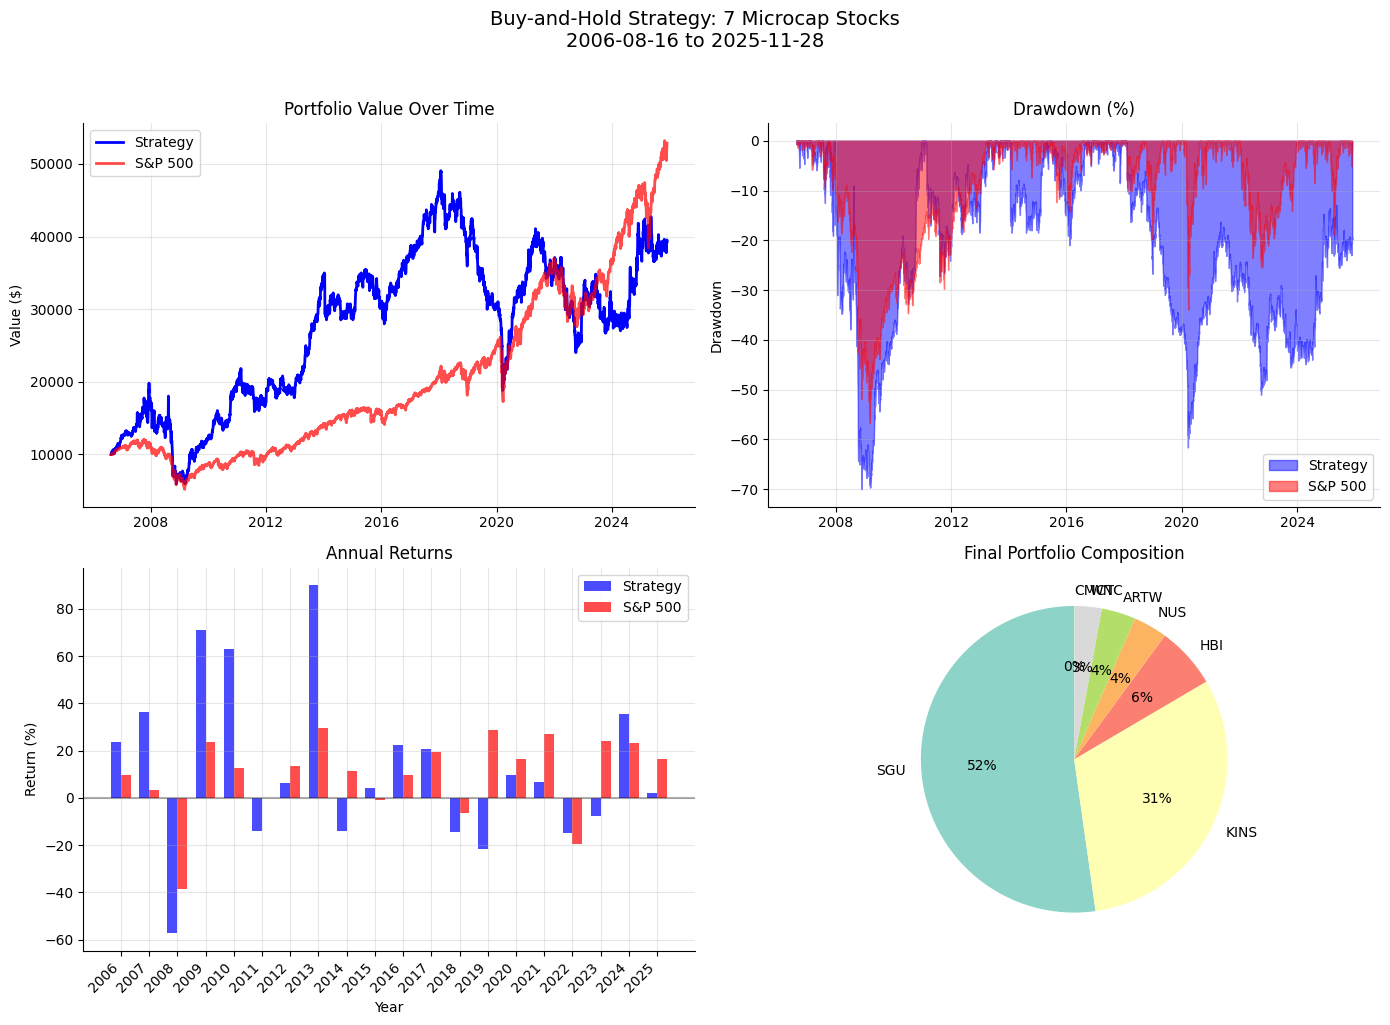

trategy underperformed S&P 500 by 135.6%
Best performer: SGU
Worst performer: CMCT


In [129]:
results = backtestS1(
    price_data=price_data,
    initial_capital=10000
)